# Wessels2022 Preprocessing

In [1]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
sc.settings.verbosity = 3
#sc.logging.print_header()

In [4]:
os.chdir('./../')
os.getcwd()

'/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility'

In [5]:
%load_ext autoreload
%autoreload 2 

## Download

Find the Seurat object for our combinatorial single cell screen behind this link: 'Link is removed. Please contact to the authors of the original paper.'

## Get data from RDS

convert tsv files for rna and adt counts to anndata h5ad

In [6]:
import anndata2ri

In [7]:
seurat_path = "/storage/groups/ml01/workspace/kemal.inecik/Wessel2022/THP1.CaRPoolSeq.RDS"
base_path = "/storage/groups/ml01/workspace/kemal.inecik/Wessel2022"
fname="onlyRNA"

In [8]:
anndata2ri.activate()
%load_ext rpy2.ipython

In [9]:
%%R -i seurat_path
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(Seurat))
allen <- readRDS(file = seurat_path)
allen

An object of class Seurat 
17328 features across 30707 samples within 3 assays 
Active assay: RNA (16920 features, 2000 variable features)
 2 other assays present: GUIDE, ADT
 2 dimensional reductions calculated: pca, umap


In [10]:
%%R -o adata
adata <- as.SingleCellExperiment(allen, assay = c("RNA", "GUIDE"))

In [11]:
adata

AnnData object with n_obs × n_vars = 30707 × 16920
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [12]:
%%R
DefaultAssay(object = allen) = "ADT"
names(allen)

[1] "RNA"   "GUIDE" "ADT"   "pca"   "umap" 


In [13]:
%%R
head(rownames(allen),3)

CD127-GTGTGTTGTCCTATG CD135-CAGTAGATGGAGCAT  CD29-GTATTCCCTCAGTCA 
              "CD127"               "CD135"                "CD29" 


In [14]:
%%R
names(rownames(allen))

 [1] "CD127-GTGTGTTGTCCTATG"       "CD135-CAGTAGATGGAGCAT"      
 [3] "CD29-GTATTCCCTCAGTCA"        "CD45RA-TCAATCCTTCCGCTT"     
 [5] "CD46-ACAGTACGACCTTCT"        "CD52-CTTTGTACGAGCAAA"       
 [7] "CD55-GCTCATTACCCATTA"        "CD56-TCCTTTCCTGATAGG"       
 [9] "CD59-AATTAGCCGTCGAGA"        "CD63-GAGATGTCTGCAACT"       
[11] "CD71-CCGTGTTCCTCATTA"        "CD9-GAGTCACCAATCTGC"        
[13] "CD11a-TATATCCTTGTGAGC"       "CD11b-GACAAGTGATCTGCA"      
[15] "CD11c-TACGCCTATAACTTG"       "CD123-CTTCACTCTGTCAGG"      
[17] "CD16-AAGTTCACTCTTTGC"        "CD183-GCGATGGTAGATTAT"      
[19] "CD185-AATTCAACCGTCGCC"       "CD1C-GAGCTACTTCACTCG"       
[21] "CD33-TAACTCAGGGCCTAT"        "HLA-DR-AATAGCGAGCAAGTA"     
[23] "IgM-TAGCGAGCCCGTATA"         "CD14-custom-CACATTGCGTTAGAA"


In [15]:
%%R -o adt_counts
adt_counts <- GetAssayData(object = allen, slot = "counts")

In [16]:
adt_counts = adt_counts.T
print(adt_counts.shape)
adt_counts.A

(30707, 24)


array([[ 40.,  21.,  14., ..., 818., 116.,  38.],
       [ 35.,   6.,  19., ..., 264., 104.,   9.],
       [ 38.,  13.,  23., ..., 834., 125.,  29.],
       ...,
       [  4.,   5.,   2., ..., 295.,  48.,  15.],
       [ 11.,   3.,   4., ..., 292.,  35.,   9.],
       [ 12.,   2.,   2., ..., 141.,  30.,   8.]])

In [17]:
%%R -o adt_names
adt_names = as.character(rownames(allen))

In [18]:
adt_names = np.array(adt_names)
adt_names

array(['CD127', 'CD135', 'CD29', 'CD45RA', 'CD46', 'CD52', 'CD55', 'CD56',
       'CD59', 'CD63', 'CD71', 'CD9', 'CD11a', 'CD11b', 'CD11c', 'CD123',
       'CD16', 'CD183', 'CD185', 'CD1C', 'CD33', 'HLADR', 'IgM',
       'CD14custom'], dtype='<U10')

In [19]:
%%R -o adt_data
adt_data <- GetAssayData(object = allen, slot = "data")

In [20]:
adt_data = adt_data.T
print(adt_data.shape)
adt_data.A

(30707, 24)


array([[3.43089553, 2.81539439, 2.43943037, ..., 6.41761925, 4.47417829,
        3.38130384],
       [3.97025828, 2.29394589, 3.37511359, ..., 5.97435685, 5.04670353,
        2.66521021],
       [3.42650442, 2.41449287, 2.94538685, ..., 6.48364085, 4.59435199,
        3.16624988],
       ...,
       [2.21012798, 2.41109001, 1.62105844, ..., 6.39629634, 4.5890672 ,
        3.44802727],
       [3.28312564, 2.07917909, 2.33510399, ..., 6.52521878, 4.41452013,
        3.09075613],
       [3.90682675, 2.21085096, 2.21085096, ..., 6.35211553, 4.81098162,
        3.51136355]])

In [21]:
adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype(int)
adata.obs["nCount_RNA"] = adata.obs["nCount_RNA"].astype(int)

In [22]:
adata

AnnData object with n_obs × n_vars = 30707 × 16920
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

### Merge h5ad files

In [23]:
adata.obs.index.name = "cell_ID"
adata.layers["counts"] = adata.X.copy()
adata.X = adata.layers["logcounts"].copy()
del adata.layers["logcounts"]

In [24]:
protein_data = np.array(adt_counts.A).astype(dtype=float)
protein_names = np.array(adt_names)
adata.uns['protein_names'] = protein_names
adata.obsm['protein_expression_raw'] = protein_data
protein_data = np.array(adt_data.A).astype(dtype=float)
adata.obsm['protein_expression'] = protein_data

In [28]:
adata.var.index.name = "index"

In [26]:
adata.write(os.path.join(base_path, f'THP1.CaRPoolSeq_RNA_ADT.h5ad'))

... storing 'Phase' as categorical
... storing 'PhaseWeissman' as categorical
... storing 'HTO' as categorical
... storing 'TenX.Lane' as categorical
... storing 'Guides' as categorical
... storing 'CRISPR.Array' as categorical
... storing 'GenePair' as categorical
... storing 'Guide.Class' as categorical
... storing 'ID.g1' as categorical
... storing 'ID.g2' as categorical


In [27]:
adata

AnnData object with n_obs × n_vars = 30707 × 16920
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident'
    uns: 'protein_names'
    obsm: 'X_pca', 'X_umap', 'protein_expression_raw', 'protein_expression'
    layers: 'counts'

# Check perturbations

In [6]:
base_path = "/storage/groups/ml01/workspace/kemal.inecik/Wessel2022"
adata = sc.read(os.path.join(base_path, f'THP1.CaRPoolSeq_RNA_ADT.h5ad'))

In [7]:
perts = adata.obs[['GenePair', 'Guide.Class']].drop_duplicates().reset_index(drop=True)

In [8]:
np.array(set([j for i in [i.split("_") for i in perts["GenePair"]] for j in i]))

array({'SUPT5H', 'DOT1L', 'EP300', 'HDAC3', 'MED24', 'GATA2', 'RCOR1', 'RING1', 'SSRP1', 'SMARCD1', 'MED14', 'CD14', 'MED22', 'INTS1', 'SUPT6H', 'ATXN7L3', 'FLI1', 'KDM1A', 'MED19', 'IKZF1', 'SMARCA5', 'GFI1', 'VPRBP', 'MED16', 'MED13L', 'GSE1', 'MYB', 'NT', 'SUPT16H'},
      dtype=object)

In [9]:
for gc in ["Dual", "Single", "NT"]:
    print(len(adata[adata.obs["GenePair"].isin(list(perts[perts["Guide.Class"] == gc]["GenePair"]))]))

28095
2188
424


In [10]:
a = [[i[(i.index("NT")-1)%2], "NT"] if "NT" in i else i for i in list(adata.obs["GenePair"].str.split('_'))] # bring NT second pos always
a = ["+".join(i) if not i == ["NT", "NT"] else "NT" for i in a] # replace NT+NT with NT
a[:10]

['EP300+GSE1',
 'IKZF1+SMARCD1',
 'SUPT16H+SUPT5H',
 'DOT1L+INTS1',
 'INTS1+RING1',
 'MED24+SSRP1',
 'DOT1L+GFI1',
 'GSE1+RCOR1',
 'SMARCD1+NT',
 'INTS1+NT']

In [11]:
adata.obs["condition"] = a

In [12]:
adata

AnnData object with n_obs × n_vars = 30707 × 16920
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident', 'condition'
    uns: 'protein_names'
    obsm: 'X_pca', 'X_umap', 'protein_expression', 'protein_expression_raw'
    layers: 'counts'

## Preprocess data

In [13]:
# As normalized data is obtained from rds
    # sc.pp.normalize_total(adata) 
    # sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [14]:
a=adata.var.copy()
a=a.sort_values(by=["dispersions_norm"])

for ind, i in enumerate(a['highly_variable']):
    if i:
        break
ind

14280

In [15]:
len(a)

16920

In [16]:
print(sum(a["highly_variable"]))

1465


In [17]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [18]:
adata

AnnData object with n_obs × n_vars = 30707 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'hvg'
    obsm: 'X_pca', 'X_umap', 'protein_expression', 'protein_expression_raw'
    layers: 'counts'

In [19]:
adata.X.A.max()

6.711815849485947

# Prepare for the model

In [20]:
adata.obs['dose_val'] = ["1" if i == "NT" else "1+1" for i in adata.obs['condition']]
adata.obs['cell_type'] = 'THP-1'
adata.obs['control'] = [1 if x == 'NT' else 0 for x in adata.obs.condition.values]

In [21]:
np.unique(adata.obs['control'])

array([0, 1])

In [22]:
adata.obs['drug_dose_name'] = adata.obs.condition.astype(str) + '_' + adata.obs.dose_val.astype(str)
adata.obs['cov_drug_dose_name'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.drug_dose_name.astype(str)

In [23]:
from compert.helper import rank_genes_groups_by_cov
import warnings

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', pd.errors.PerformanceWarning)
    rank_genes_groups_by_cov(adata, groupby='cov_drug_dose_name', covariate='cell_type', control_group='NT_1', n_genes=20)

THP-1
ranking genes


/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


In [25]:
adata

AnnData object with n_obs × n_vars = 30707 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident', 'condition', 'dose_val', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'hvg', 'rank_genes_groups_cov'
    obsm: 'X_pca', 'X_umap', 'protein_expression', 'protein_expression_raw'
    layers: 'counts'

In [26]:
print(type(adata.uns["rank_genes_groups_cov"]))
#for i in adata.uns["rank_genes_groups_cov"]:
#    print(f"{i}: {len(adata.uns['rank_genes_groups_cov'][i])}")

<class 'dict'>


In [27]:
adata.uns['protein_names']

array(['CD127', 'CD135', 'CD29', 'CD45RA', 'CD46', 'CD52', 'CD55', 'CD56',
       'CD59', 'CD63', 'CD71', 'CD9', 'CD11a', 'CD11b', 'CD11c', 'CD123',
       'CD16', 'CD183', 'CD185', 'CD1C', 'CD33', 'HLADR', 'IgM',
       'CD14custom'], dtype=object)

In [28]:
_keep_col = [i for i in range(len(adata.uns['protein_names'])) if i != list(adata.uns['protein_names']).index('IgM')]
adata.obsm['protein_expression_raw'] = adata.obsm['protein_expression_raw'][:,_keep_col]
adata.obsm['protein_expression'] = adata.obsm['protein_expression'][:,_keep_col]
adata.uns['protein_names'] = adata.uns['protein_names'][_keep_col]

# Visualization

In [ ]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50


In [ ]:
sc.pl.pca_scatter(adata, color=['nCount_RNA', 'nFeature_RNA', 'percent.mt'])
sc.pl.umap(adata, color=['nCount_RNA', 'nFeature_RNA', 'percent.mt'])

In [ ]:
sc.pl.umap(adata, color=['Guide.Class', 'PhaseWeissman', 'Phase'], size=10)

In [ ]:
sc.tl.louvain(adata)

In [ ]:
sc.pl.umap(adata, color='louvain')

# Splits

In [29]:
adata.obs['split'] = 'nan'
for cov_drug_dose_name in np.unique(adata.obs["cov_drug_dose_name"]):
    adata_idx = adata.obs_names[adata.obs["cov_drug_dose_name"] == cov_drug_dose_name]
    # print(f"{cov_drug_dose_name}\t{len(adata_idx)}")
    adata_idx_train, adata_idx_test = train_test_split(adata_idx, test_size=0.15, random_state=42)
    adata.obs.loc[adata_idx_train, 'split'] = 'train'
    adata.obs.loc[adata_idx_test, 'split'] = 'test'
adata_idx = adata.obs_names
_, adata_idx_ood = train_test_split(adata_idx, test_size=0.0003, random_state=42)
adata.obs.loc[adata_idx_ood, 'split'] = 'ood'

In [30]:
adata.obs['split2'] = 'nan'
for cov_drug_dose_name in np.unique(adata.obs["cov_drug_dose_name"]):
    adata_idx = adata.obs_names[adata.obs["cov_drug_dose_name"] == cov_drug_dose_name]
    # print(f"{cov_drug_dose_name}\t{len(adata_idx)}")
    adata_idx_train, adata_idx_test = train_test_split(adata_idx, test_size=0.10, random_state=42)
    adata.obs.loc[adata_idx_train, 'split2'] = 'train'
    adata.obs.loc[adata_idx_test, 'split2'] = 'test'
adata_idx = adata.obs_names
ood_groups = ['THP-1_FLI1+INTS1_1+1', 'THP-1_HDAC3+SMARCD1_1+1', 'THP-1_DOT1L+EP300_1+1', 'THP-1_KDM1A+SMARCD1_1+1']
adata.obs.loc[adata.obs.index[adata.obs["cov_drug_dose_name"].isin(ood_groups)], 'split2'] = 'ood'

In [31]:
adata.obs.groupby('split').size()

split
ood         10
test      4694
train    26003
dtype: int64

In [32]:
adata.obs.groupby('split2').size()

split2
ood       1133
test      3032
train    26542
dtype: int64

In [33]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(pd.DataFrame(adata.obs.groupby("cov_drug_dose_name").size()).sort_values(by=[0]))

## Remove Outlier Genes

<AxesSubplot:ylabel='Count'>

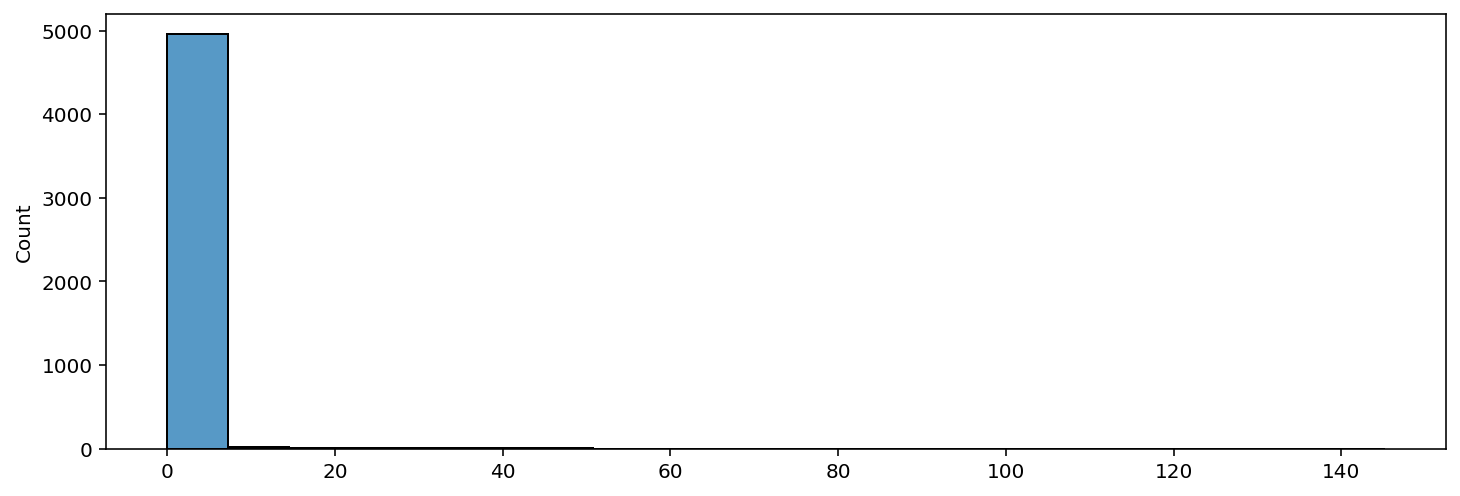

In [34]:
mean_genes = adata.layers['counts'].mean(0)
mean_genes = np.array(mean_genes)[0]
plt.figure(figsize=(12,4))
sns.histplot(sorted(mean_genes), bins=20)

In [35]:
THR = 50
adata = adata[:, adata.var[mean_genes < THR].index]
adata

View of AnnData object with n_obs × n_vars = 30707 × 4992
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident', 'condition', 'dose_val', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name', 'split', 'split2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'hvg', 'rank_genes_groups_cov'
    obsm: 'X_pca', 'X_umap', 'protein_expression', 'protein_expression_raw'
    layers: 'counts'

# Write

In [36]:
adata.write(os.path.join(base_path, f'Wessel22_prep.h5ad'))

/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/kemal.inecik/miniconda3/envs/scvienv/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[

#### No Protein

In [37]:
adata.obsm['protein_expression'] = np.array([[]]*len(adata.obsm['protein_expression']))
adata.obsm['protein_expression_raw'] = np.array([[]]*len(adata.obsm['protein_expression_raw']))

In [38]:
adata.uns['protein_names'] = np.array([])

In [39]:
adata.write(os.path.join(base_path, f'Wessel22_noprot_prep.h5ad'))

In [40]:
adata

AnnData object with n_obs × n_vars = 30707 × 4992
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'PhaseWeissman', 'nCount_HTO', 'HTO', 'nCount_ADT', 'TenX.Lane', 'Guides', 'nCount_GUIDE', 'CRISPR.Array', 'GenePair', 'Guide.Class', 'UMI.g1', 'UMI.g2', 'ID.g1', 'ID.g2', 'fraction.g1.over.all', 'fraction.g1.over.g2', 'g1.by.g2', 'ident', 'condition', 'dose_val', 'cell_type', 'control', 'drug_dose_name', 'cov_drug_dose_name', 'split', 'split2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'hvg', 'rank_genes_groups_cov'
    obsm: 'X_pca', 'X_umap', 'protein_expression', 'protein_expression_raw'
    layers: 'counts'